## **Importação das bibliotecas e dados (AEP e Duas Unas)**

In [33]:
# %pip install ipykernel --break-system-packages
# %pip install scikit-learn --break-system-packages
# %pip install matplotlib --break-system-packages
# %pip install keras --break-system-packages
# %pip install tensorflow --break-system-packages
# %pip install pandas --break-system-packages
# %pip install plotly --break-system-packages
# %pip install seaborn --break-system-packages
# %pip install nbformat --break-system-packages
# %pip install keras --break-system-packages
# %pip install pswarm


In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.initializers import GlorotUniform    #Inicializador de pesos
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.activations import relu
from keras.initializers import GlorotUniform
from keras.initializers import GlorotNormal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf #Biblioteca para machine learning

In [35]:

base_path = './dataset/'

# carregando arquivo CSV
time_base = 'days'  # Escolha do tipo de agrupamento
duas_unas_dataset = f'{base_path}duas_unas/{time_base}/grouped_7_{time_base}.csv'  # Definição do caminho do diretório do dataset

validation_interval = 13  # Definição da parcela dos dados que serão retiradas do treinamento/teste para validação
time_step = 1  # Number of previous time steps to consider
output_steps = 12  # Number of future steps to predict

# transformando CSV em DataFrame
duas_unas_df = pd.read_csv(duas_unas_dataset)  # Transformação em dataset

duas_unas_validation = duas_unas_df.tail(validation_interval)  # Criação do dataset de validação

indices_to_validate = duas_unas_df.index[-validation_interval:].tolist()  # Obtenção dos índices dos dadoss de validação
duas_unas_df = duas_unas_df.drop(indices_to_validate).reset_index(drop=True)  # Retirada dos dados de validação do dataset original de treino/teste

duas_unas_df['timestamp'] = pd.to_datetime(duas_unas_df['timestamp'])  # Transformação dos dados da coluna 'timestamp' no formato datetime. Ela lida com vários formatos de data/hora e tenta interpretá-los de forma inteligente.
duas_unas_validation['timestamp'] = pd.to_datetime(duas_unas_validation['timestamp'])  # Idem da ação da linha de cima.

duas_unas_df['index'] = range(len(duas_unas_df))  # Criação da coluna 'index' em que os valores vão de zero ao tamanho total do daframe
duas_unas_validation['index'] = indices_to_validate  # Idem da acima da linha acima
#print(indices_to_validate)
duas_unas_df['kwh'] = duas_unas_df['kWh fornecido']  # Criação da coluna 'kwh' que copia os dados da coluna 'kWh fornecido'
duas_unas_validation['kwh'] = duas_unas_validation['kWh fornecido']  # Idem da acima da linha acima

duas_unas_df.drop(columns=['timestamp'], inplace=True)  # Remoção da coluna 'timestamp', inclusive no dataframe original
duas_unas_validation.drop(columns=['timestamp'], inplace=True)  # Idem da acima da linha acima

duas_unas_df.drop(columns=['kWh fornecido'], inplace=True)  # Remoção da coluna 'kWh fornecido', inclusive no dataframe original
duas_unas_validation.drop(columns=['kWh fornecido'], inplace=True)  # Idem da acima da linha acima
print(duas_unas_df)
# X = duas_unas_df['index'].values.reshape(-1,1)  # Cria o array X com os índices do dataframe duas_unas_df
# y = duas_unas_df['kwh'].values  # Cria o array y com os dados de energia de duas_unas_df
# #print(y)
# X_validation = duas_unas_validation['index'].values.reshape(-1,1)  # Cria o array X_validation com os índices do dataframe duas_unas_validation
# y_validation = duas_unas_validation['kwh'].values  # Cria o array y com os dados de energia de duas_unas_validation
# #print(X_validation)

    index        kwh
0       0   39153.24
1       1  141320.52
2       2  146671.56
3       3  124645.32
4       4  146279.52
5       5  145839.96
6       6  147657.60
7       7  138212.64
8       8  147140.64
9       9  148873.32
10     10  143710.92
11     11  145474.56
12     12  147323.52
13     13  147251.52
14     14  145724.76
15     15  143252.64
16     16  135256.32
17     17  139863.60
18     18  143287.56
19     19  144475.92
20     20  144952.92
21     21  144999.36
22     22  145198.80
23     23  121432.68
24     24  145365.84
25     25  138715.56
26     26  130745.16
27     27  145145.88
28     28  142728.48
29     29  146224.08
30     30  139841.28
31     31  134984.16


In [36]:
import tensorflow as tf

def identify_peaks_and_valleys(y_test):
    # Converte y_test em um tensor
    #y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    # Inicializa pesos como um tensor de 1s do mesmo formato
    weights = tf.ones(tf.shape(y_test), dtype=tf.float32)

    # Condicional para verificar se y_test tem pelo menos 3 elementos
    mask = tf.size(y_test) < 3

    # Função para processar picos e vales
    def process_peaks_and_valleys():
        # Certifique-se de que y_test é do tipo float32
        y_test_float = tf.cast(y_test, tf.float32)

        # Obtém os índices de picos e vales para elementos intermediários
        # Corrigido: use tf.expand_dims para garantir que o primeiro elemento tenha o formato correto
        y_test_prev = tf.concat([tf.expand_dims(y_test_float[0], axis=0), y_test_float[:-1]], axis=0)  # Adiciona o primeiro elemento como anterior
        y_test_next = tf.concat([y_test_float[1:], tf.expand_dims(y_test_float[-1], axis=0)], axis=0)  # Adiciona o último elemento como próximo

        # Define picos e vales para os elementos intermediários
        peaks = tf.where((y_test_float > y_test_prev) & (y_test_float > y_test_next))
        valleys = tf.where((y_test_float < y_test_prev) & (y_test_float < y_test_next))

        # Atualiza os pesos para picos e vales intermediários
        weights_updated = tf.tensor_scatter_nd_update(weights, peaks, tf.fill(tf.shape(peaks)[:1], 3.0))
        weights_updated = tf.tensor_scatter_nd_update(weights_updated, valleys, tf.fill(tf.shape(valleys)[:1], 3.0))

    #     # Verificação para o primeiro elemento
    #     first_idx = 0
    #     first_elem = tf.gather(y_test, first_idx)
    #     second_elem = tf.gather(y_test, first_idx + 1)
    #     third_elem = tf.gather(y_test, first_idx + 2)

    #     # Atualiza o peso do primeiro elemento
    #     first_weight_update = tf.where(
    #         (first_elem < second_elem) & (first_elem < third_elem) |
    #         (first_elem > second_elem) & (first_elem > third_elem),
    #         3.0,
    #         weights_updated[first_idx]
    #     )
    #     weights_updated = tf.tensor_scatter_nd_update(weights_updated, [[first_idx]], [first_weight_update])


    #     # Verificação para o último elemento
    #     last_idx = tf.shape(y_test)[0] - 1
    #     last_elem = tf.gather(y_test, last_idx)
    #     second_last_elem = tf.gather(y_test, last_idx - 1)
    #     third_last_elem = tf.gather(y_test, last_idx - 2)

    # # Atualiza o peso do último elemento
    #     last_weight_update = tf.where(
    #         (last_elem < second_last_elem) & (last_elem < third_last_elem) |
    #         (last_elem > second_last_elem) & (last_elem > third_last_elem),
    #         3.0,
    #         weights_updated[last_idx]
    #     )
    #     weights_updated = tf.tensor_scatter_nd_update(weights_updated, [[last_idx]], [last_weight_update])

        return weights_updated

    # Condicional para executar a função de processamento se y_test tiver 3 ou mais elementos
    weights = tf.cond(mask, lambda: weights, process_peaks_and_valleys)

    return weights


In [37]:
# Função WMAE ajustada com pesos para picos e vales
def wmae(y_test, y_pred):
    # Convertendo y_test e y_pred para float32
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    #y_test = tf.squeeze(y_test)
    #y_pred = tf.squeeze(y_pred)

    weights = identify_peaks_and_valleys(y_test)

    return (tf.reduce_sum(weights * tf.abs(y_test - y_pred)) / tf.reduce_sum(weights))

In [38]:
def create_dataset(data, time_step, output_steps):  # Função para construção do dataset
    X, y = [], []  # Criação das listas
    for i in range(len(data) - time_step - output_steps + 1):  # Loop
        X.append(data[i:(i + time_step), 0])  # Construção do dataset 
        y.append(data[(i + time_step):(i + time_step + output_steps), 0])
    return np.array(X), np.array(y)

In [39]:
def avaliacao_multistep(janela_real, janela_prevista):

    if len(janela_real) != len(janela_prevista):
        raise ValueError("As janelas reais e previstas devem ter o mesmo comprimento.")
    
    janela_real = np.array(janela_real)
    janela_prevista = np.array(janela_prevista)

    print(janela_real[0])
    
    mae_med = 0
    mse_med = 0
    rmse_med = 0
    mape_med = 0
    acuracia_med = 0
    # Converte as listas para arrays NumPy
    #janela_real = np.array(janela_real)
    #janela_prevista = np.array(janela_prevista)

    mae = round(mean_absolute_error(janela_real, janela_prevista), 3) # Arredondamento com três casas decimais
    print("MAE(Erro absoluto médio) Score of LSTM model = ",mae)
    print(" ")

    mse = round(mean_squared_error(janela_real, janela_prevista), 3)
    print("MSE(Erro quadrático médio) Score of LSTM model = ",mse)
    print(" ")
            
    rmse = round(np.sqrt(mse), 3)
    print("RMSE(Raiz do erro quadrático médio) Score of LSTM model = ",rmse)
    print(" ")

    mape = round(mean_absolute_percentage_error(janela_real, janela_prevista), 2)
    print("MAPE(Erro percentual médio absoluto) Score of LSTM model = ",mape)
    print(" ")
            
    ### Cálculo da ACURÁCIA ###
            
    # Calcula a diferença percentual
    diferencas_percentuais = np.abs((janela_real - janela_prevista) / janela_real)
    # print(f"dif_perc",diferencas_percentuais)
    # print("len(janela_real)",len(janela_real))

    # Conta quantas diferenças percentuais estão dentro da tolerância
    acertos = np.sum(diferencas_percentuais <= 0.05) #0.05 é a tolerância

    # Calcula a acurácia
    acuracia = acertos / len(janela_real)   
    acuracia = round(100 * acuracia, 2)
            
    print("Accuracy Score of LSTM model = ",acuracia)
    
    # mae_med += mae
    # mse_med += mse
    # rmse_med += rmse
    # mape_med += mape
    # acuracia_med += acuracia
            
    # mae_med = mae_med/(len(janela_prevista))
    # mse_med /=(len(janela_prevista))
    # rmse_med /=(len(janela_prevista))
    # mape_med /=(len(janela_prevista))
    # acuracia_med /=(len(janela_prevista))
    
    return round(mae,2), round(mse,2), round(rmse,2), round(mape,2), round(acuracia,2)

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Padronização dos dados
scaled_kwh = scaler.fit_transform(duas_unas_df['kwh'].values.reshape(-1, 1))  # padronização de duas_unas_df

scaled_kwh_validation = scaler.fit_transform(duas_unas_validation['kwh'].values.reshape(-1,1))  # padronização de duas_unas_validacao

# Create the dataset
X, y = create_dataset(scaled_kwh, time_step, output_steps)
X_validation, y_validation = create_dataset(scaled_kwh_validation, time_step, output_steps)
print(f"X_validation", X_validation)
print(f"y_validation", y_validation)
# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_test.shape)
print(y_test.shape)

print(f"X_test", X_test)
print(f"y_test", y_test)

X_validation [[0.68727164]]
y_validation [[0.92966925 0.92986695 0.92090811 0.94777731 0.94113232 0.9448191
  0.88109307 0.95762582 0.88882909 0.96186177 1.         0.        ]]
(10, 1, 1)
(10, 12)
X_test [[[0.        ]]

 [[0.91788449]]

 [[0.94877255]]

 [[0.93116301]]

 [[0.98420818]]

 [[0.97235365]]

 [[0.96902335]]

 [[0.77918354]]

 [[0.94909081]]

 [[0.87589327]]]
y_test [[0.93116301 0.97993293 0.77918354 0.97635984 0.97235365 0.9889198
  0.90283748 0.98420818 1.         0.95294936 0.96902335 0.98587496]
 [0.94909081 0.95992165 0.96426907 0.96469233 0.96651005 0.74990321
  0.96803247 0.90742114 0.8347781  0.96602773 0.9439953  0.97585456]
 [0.87589327 0.91788449 0.94909081 0.95992165 0.96426907 0.96469233
  0.96651005 0.74990321 0.96803247 0.90742114 0.8347781  0.96602773]
 [0.97993293 0.77918354 0.97635984 0.97235365 0.9889198  0.90283748
  0.98420818 1.         0.95294936 0.96902335 0.98587496 0.98521875]
 [1.         0.95294936 0.96902335 0.98587496 0.98521875 0.9713037
  0.

In [41]:
def main_looping(output_steps, X_train, y_train, X_validation, y_validation):


    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(104, return_sequences=True, input_shape=(X_train.shape[1], 1),
                        kernel_initializer=GlorotUniform(),     # Inicializa os pesos
                        recurrent_initializer=GlorotUniform(),  # Inicializa os pesos recorrentes
                        bias_initializer=GlorotUniform()))       # Inicializa os bias
    model.add(Dropout(0.32))
    model.add(LSTM(104, return_sequences=True,
                        kernel_initializer=GlorotUniform(),     # Inicializa os pesos
                        recurrent_initializer=GlorotUniform(),  # Inicializa os pesos recorrentes
                        bias_initializer=GlorotUniform()))       # Inicializa os bias
    model.add(Dropout(0.32))
    model.add(LSTM(104, return_sequences=False,
                        kernel_initializer=GlorotUniform(),     # Inicializa os pesos
                        recurrent_initializer=GlorotUniform(),  # Inicializa os pesos recorrentes
                        bias_initializer=GlorotUniform()))       # Inicializa os bias
    model.add(Dropout(0.32))
    model.add(Dense(output_steps, activation="relu",kernel_initializer=GlorotUniform()))

    learning_rate = 0.01
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=wmae)

    early_stopping = EarlyStopping(monitor='val_loss', verbose=2, patience=9, restore_best_weights=True)
    #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=2, verbose=0, mode='auto')
    history = model.fit(X_train, y_train, epochs=10000, batch_size=20, validation_data=(X_validation, y_validation), callbacks=[early_stopping])
    # Train the model
    #history = model.fit(X_train, y_train, epochs=1000, batch_size=4, verbose=1, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1))

    # Plotar as perdas de treinamento e validação
    plt.plot(history.history['loss'], label='Loss de Treinamento')
    plt.plot(history.history['val_loss'], label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

    return model

Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9323 - val_loss: 0.9100
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.9091 - val_loss: 0.8667
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.8670 - val_loss: 0.8052
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8039 - val_loss: 0.7112
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7313 - val_loss: 0.5612
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5733 - val_loss: 0.3636
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4034 - val_loss: 0.4376
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.5472 - val_loss: 0.4319
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4468 - val_loss: 0.3109
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3738 - val_loss: 0.2000
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2760 - val_loss: 0.2537
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2777 

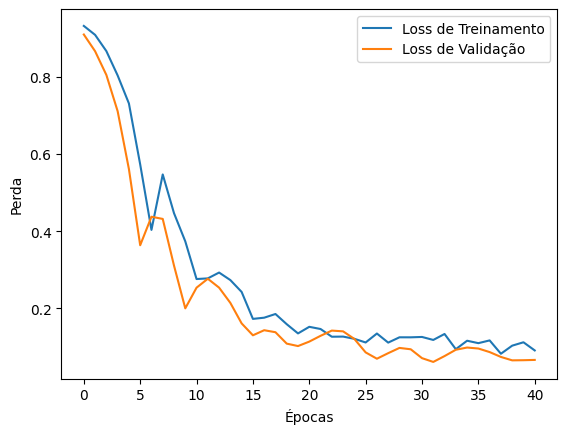

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.9288 - val_loss: 0.8862
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8859 - val_loss: 0.8330
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.8375 - val_loss: 0.7557
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7610 - val_loss: 0.6341
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6240 - val_loss: 0.4412
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4375 - val_loss: 0.2764
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2815 - val_loss: 0.4106
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4627 - val_loss: 0.3518
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3003 - val_loss: 0.2067
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2381 - val_loss: 0.1717
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1916 - val_loss: 0.2445
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2482 

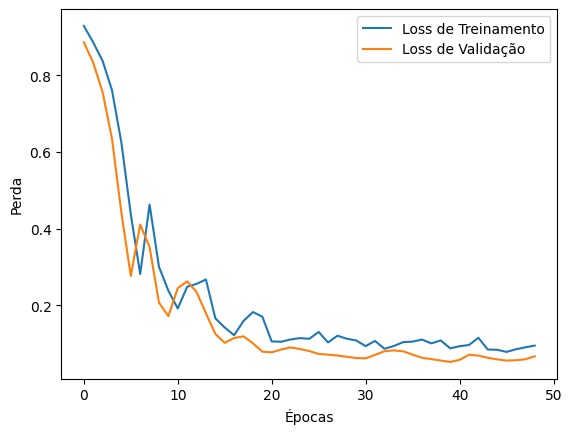

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9307 - val_loss: 0.9007
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.9024 - val_loss: 0.8533
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8568 - val_loss: 0.7861
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7891 - val_loss: 0.6838
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6715 - val_loss: 0.5230
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.5007 - val_loss: 0.3316
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3530 - val_loss: 0.3727
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4170 - val_loss: 0.3496
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.3603 - val_loss: 0.2280
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3073 - val_loss: 0.1380
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1680 - val_loss: 0.1870
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1874 

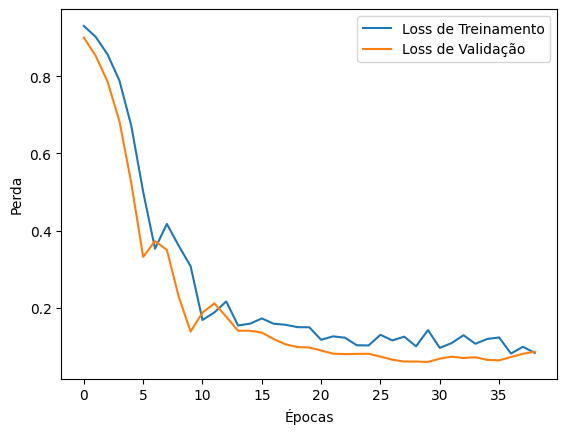

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9216 - val_loss: 0.8835
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8826 - val_loss: 0.8321
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.8340 - val_loss: 0.7564
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7667 - val_loss: 0.6374
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6428 - val_loss: 0.4484
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4464 - val_loss: 0.3307
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3833 - val_loss: 0.4734
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4938 - val_loss: 0.4409
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4370 - val_loss: 0.2988
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.3703 - val_loss: 0.1851
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2455 - val_loss: 0.2576
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2812 

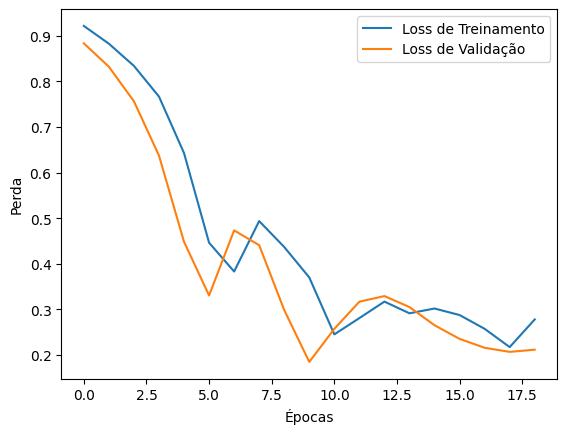

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.9350 - val_loss: 0.8934
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8974 - val_loss: 0.8475
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.8496 - val_loss: 0.7769
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7915 - val_loss: 0.6616
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6796 - val_loss: 0.4754
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4647 - val_loss: 0.3154
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3146 - val_loss: 0.4042
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4174 - val_loss: 0.3683
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4313 - val_loss: 0.2334
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2596 - val_loss: 0.1383
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1899 - val_loss: 0.2094
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1993 

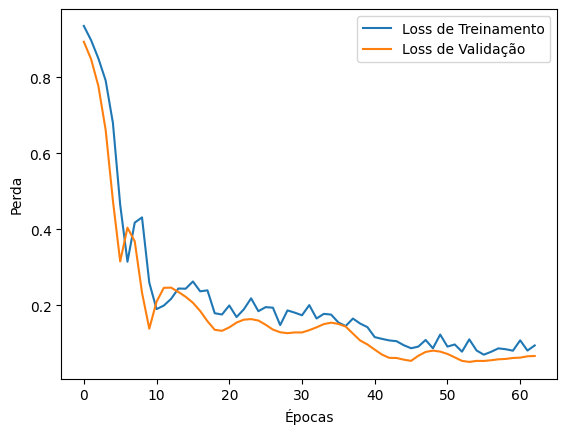

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9341 - val_loss: 0.8954
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8934 - val_loss: 0.8474
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8439 - val_loss: 0.7789
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.7720 - val_loss: 0.6719
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.6758 - val_loss: 0.4987
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.5133 - val_loss: 0.3242
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3206 - val_loss: 0.4249
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4667 - val_loss: 0.3949
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3664 - val_loss: 0.2662
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2863 - val_loss: 0.2085
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2843 - val_loss: 0.2709
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2948 

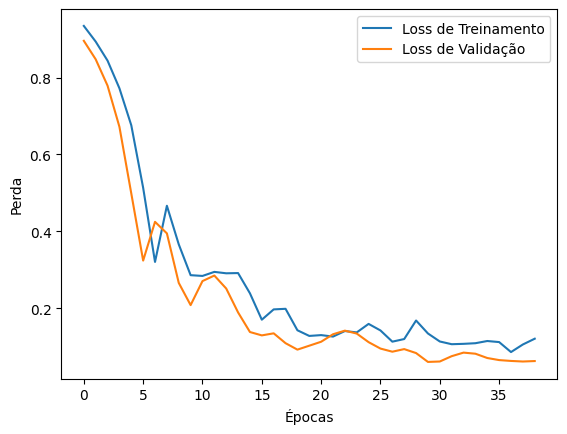

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9250 - val_loss: 0.8840
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.8795 - val_loss: 0.8295
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8258 - val_loss: 0.7479
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.7407 - val_loss: 0.6154
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6191 - val_loss: 0.3990
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3988 - val_loss: 0.2503
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3090 - val_loss: 0.2888
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3197 - val_loss: 0.2118
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2773 - val_loss: 0.1168
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1661 - val_loss: 0.1520
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1762 - val_loss: 0.1794
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1902 

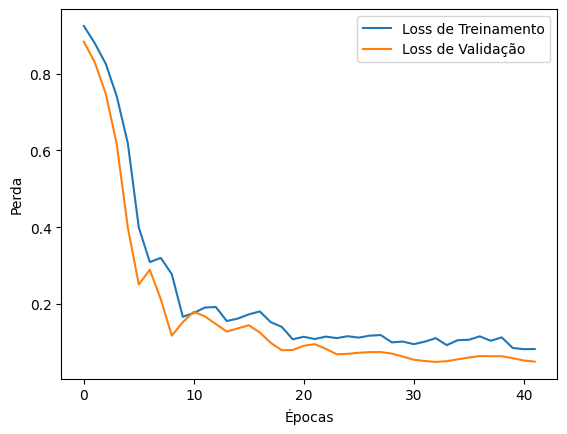

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9274 - val_loss: 0.8905
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - loss: 0.8932 - val_loss: 0.8355
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8356 - val_loss: 0.7533
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7445 - val_loss: 0.6225
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6228 - val_loss: 0.4084
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4251 - val_loss: 0.2662
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3015 - val_loss: 0.3462
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3613 - val_loss: 0.2622
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2833 - val_loss: 0.1229
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1651 - val_loss: 0.1063
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1355 - val_loss: 0.1722
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1726

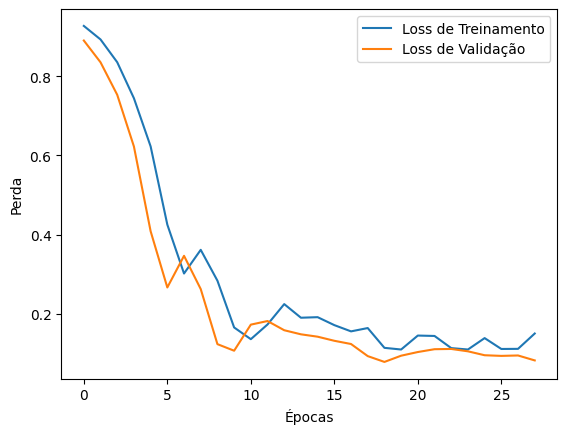

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9394 - val_loss: 0.8984
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.8968 - val_loss: 0.8506
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8498 - val_loss: 0.7796
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7838 - val_loss: 0.6685
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6639 - val_loss: 0.4926
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4825 - val_loss: 0.3428
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3847 - val_loss: 0.3947
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4017 - val_loss: 0.3683
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3728 - val_loss: 0.2477
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2826 - val_loss: 0.1904
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2192 - val_loss: 0.2467
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2256 

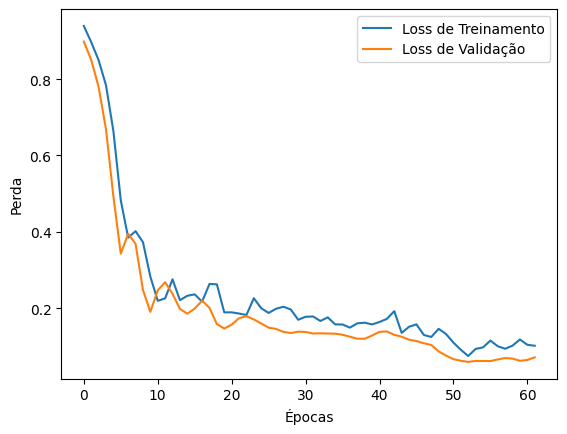

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Epoch 1/10000


c:\Users\renantorres\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9317 - val_loss: 0.9078
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.9104 - val_loss: 0.8665
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8587 - val_loss: 0.8018
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.8002 - val_loss: 0.7006
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6870 - val_loss: 0.5324
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.5063 - val_loss: 0.3102
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3478 - val_loss: 0.2657
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3266 - val_loss: 0.3177
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3573 - val_loss: 0.1935
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2432 - val_loss: 0.0828
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1498 - val_loss: 0.1707
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1705 

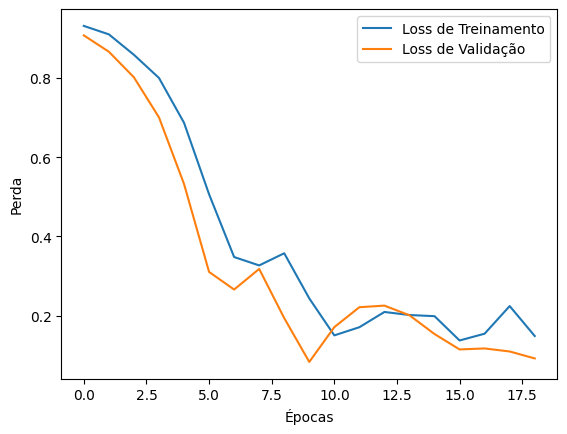

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


In [42]:
iter_prev = []
rep = 1
for i in range(rep):
    model = main_looping(output_steps, X_train, y_train, X_test, y_test)
    #print(f"X_validation", X_validation)
    y_pred = model.predict(X_validation)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    #print(f"y_pred_rescaled",y_pred_rescaled)
    iter_prev.append(y_pred_rescaled)

In [43]:
# # print(iter_prev[4][0][0])
# # print(len(iter_prev[0][0]))
# iter_prev[4][0][11]

In [44]:
# print(X_validation)
# print(iter_prev[0][0])
med =[]
soma = 0
media = 0
for j in range(len(iter_prev[0][0])):
    for i in range(rep):
        soma += iter_prev[i][0][j]
    media = soma/rep
    med.append(media)
    soma = 0
    media = 0
        

In [45]:
med

[154069.35,
 155215.0390625,
 152795.6625,
 151399.4765625,
 148374.51953125,
 153765.6296875,
 154087.0296875,
 151872.78125,
 153557.415625,
 143109.17109375,
 146898.65625,
 151444.2796875]

In [46]:
y_pred_med = np.mean(iter_prev)
print(y_pred_med)

151382.42


[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
151382.417578125


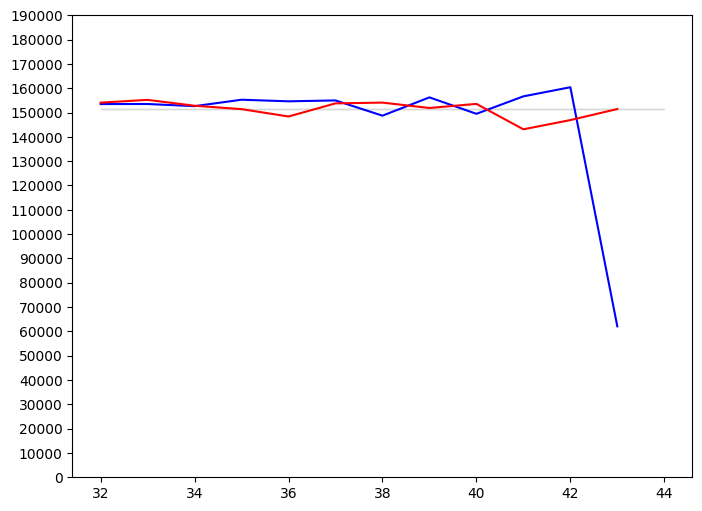

[153489.96]
MAE(Erro absoluto médio) Score of LSTM model =  12002.032
 
MSE(Erro quadrático médio) Score of LSTM model =  706330133.295
 
RMSE(Raiz do erro quadrático médio) Score of LSTM model =  26576.872
 
MAPE(Erro percentual médio absoluto) Score of LSTM model =  0.15
 
Accuracy Score of LSTM model =  75.0


(12002.03, 706330133.3, 26576.87, 0.15, 75.0)

In [47]:
# # Verifique os comprimentos das janelas
# print(f"Tamanho de y_test_rescaled: {len(y_test_rescaled)}")
# print(f"Tamanho de y_pred_rescaled: {len(med)}")
# y_pred = model.predict(X_validation)
# print(len(X_validation), len(y_pred), len(X_validation[0]))
# y_pred_rescaled = scaler.inverse_transform(y_pred)
med = np.array(med)
y_validation_reshaped = y_validation.reshape(-1, 1)
# y_test_rescaled = scaler.inverse_transform(y_validation)

y_test_rescaled = scaler.inverse_transform(y_validation_reshaped)
#indices_to_validate = indices_to_validate[:len(y_pred_rescaled)]
indices_to_validate = indices_to_validate[:validation_interval]
print(indices_to_validate)
means = np.mean(med)
stds = np.std(y_test_rescaled[0]) 
print(means) 

plt.figure(figsize=(8,6))
plt.plot(indices_to_validate[0:output_steps], y_test_rescaled, label="Original", color='blue')
plt.plot(indices_to_validate[0:output_steps], med, label="Predição", color='red')
plt.fill_between(indices_to_validate, means - stds, means + stds, color='gray', alpha=0.3, label=f'±1 Desvio Padrão ({stds:.2f})')
#plt.plot([indices_to_validate[0],indices_to_validate[12]], [means, means], color='yellow', linestyle='--', label=f'Média ({means:.2f})')
plt.yticks(np.arange(0,200000,step=10000))
plt.show()

# Adicionando uma nova dimensão
y_pred_2d = med.reshape(-1, 1)

# print("Tamanho de y_test_rescaled:", len(y_test_rescaled))
# print("Tamanho de med:", len(y_pred_2d))

# print("y_test_rescaled:", y_test_rescaled)
# print("y_pred_rescaled:", y_pred_2d)

avaliacao_multistep(y_test_rescaled,y_pred_2d)


In [48]:
# Melhor solução encontrada: [8.62753970e+01 4.69798652e-01 8.21933652e-03 1.15558296e+01
#  1.27279632e+02 3.18523512e+00 5.12027272e+00 7.84886166e-01
#  1.56826202e+00 1.59136446e+00]
# Melhor score: 0.0011546079767867923

